# **DELTA ELEMENT 2: TIME SERISE FORECASTING USING RNN**
This notebook focuses on the development, training, and evaluation of neural network models for handling time-series data. Key concepts and techniques discussed include:

- **Time-Series Data Handling**: The use of functions to prepare time-series data for modeling with RNNs.

- **Data Partitioning**: Dividing data into training and test sets to ensure a robust evaluation of model performance and avoid overfitting. (Note: Last 20% of data from the laballed dataset forms the testset)

- **Model Checkpoints**: For saving the best performing models during training to prevent data loss and facilitate easy reloading for further use.

- **Training and Evaluation**: For assessing whether training was successful, including monitoring metrics like loss and accuracy on both training and validation datasets.

- **Model Performance Analysis**: Examining model performance through the evolution of training and validation loss, with specific attention to signs of overfitting or underfitting.

- **Visualization and Metrics**: Use of custom functions to plot model predictions against actual values and calculate the Mean Squared Error (MSE) to evaluate model accuracy.

- **RNN Architectures**: GRU (Gated Recurrent Unit) and LSTM (Long Short-Term Memory) networks and their capabilities to capture long-term dependencies in sequential data.

In [183]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [184]:
df_orig = pd.read_csv('Train_Time_Series.csv', index_col='Date')

In [185]:
features = df_orig[df_orig.columns[0:320]]  # Created a dataset for scaling the 320 features saperately

In [186]:
tgt = df_orig[['Trading Volume (Target Variable)']]
#tgt.plot()

# **Scaling**
The cell below scales the data.
I have used standard scaler and defined two independent scales, one for 320 features and one for the Target Variable 'Trading Volume (Target Variable)'. This eases the process of inverse transforming the predictions.

In [188]:
from sklearn.preprocessing import StandardScaler

sc1 = StandardScaler()  # Initialize the StandardScaler for scaling features
df_features = pd.DataFrame(sc1.fit_transform(features))

sc2 = StandardScaler()  # Initialize the StandardScaler for scaling the target variable
df_tgt = pd.DataFrame(sc2.fit_transform(tgt))

In [189]:
df_scaled = pd.concat([df_features, df_tgt], axis=1) # Concatenate the scaled features and the scaled target variiable
df_scaled.columns = df_orig.columns

In [190]:
#df_scaled.head()

# **Data preparation for feeding and evaluating the model**

In [196]:
def df_to_X_y(df, window_size=5):

  """
   Converts a DataFrame into a format suitable for time series forecasting or supervised learning.

    This function transforms the input DataFrame into a set of input-output pairs for training machine   learning models.
    Each input consists of a sequence of `window_size` consecutive rows, and each output is the value from a specified column
    in the row immediately following the sequence.
    """

  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][-1]
    y.append(label)
  return np.array(X), np.array(y)

In [197]:
X1, y1 = df_to_X_y(df_scaled)
X1.shape, y1.shape

((2098, 5, 321), (2098,))

In [198]:
X1_train, y1_train = X1[:1680], y1[:1680]  # 80% data used for training
X1_val, y1_val = X1[1680:], y1[1680:]      # 20% data used for vaildation
X1_train.shape, y1_train.shape, X1_val.shape, y1_val.shape

((1680, 5, 321), (1680,), (418, 5, 321), (418,))

# **TensorFlow Keras Model Setup**
The section sets up basic neural network model using TensorFlow's Keras API.
Starting with the import of necessary modules and components for constructing and training a neural network.

In [199]:
# Sequential model type and necessary layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

# ModelCheckpoint callback for saving model checkpoints
from tensorflow.keras.callbacks import ModelCheckpoint

# Loss function and metrics for evaluation
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

# Optimizers for training the model
from tensorflow.keras.optimizers import Adam, RMSprop

# **Setting up the LSTM(64) model**

In [201]:
# Define the model

# L2 regularization to penalize large weights for preventing overfitting.
from tensorflow.keras.regularizers import l2

model1 = Sequential()
model1.add(LSTM(64, input_shape=(5, 321), kernel_regularizer=l2(0.001)))
model1.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001)))
model1.add(Dense(1, activation='linear'))

# model1.add(LSTM(32, input_shape=(5, 321), return_sequences=True))
# model1.add(Dropout(0.5))          # Dropout with 50% rate
# model1.add(LSTM(32))              # LSTM layer with 64 units
# model1.add(Dense(8, 'relu'))      # Dense layer with 8 units and Relu activation function
# model1.add(Dropout(0.5))          # Another Dropout layer
# model1.add(Dense(1, 'linear'))    # Output layer with linear activation activation

model1.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                       │ (None, 64)                  │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,345 (388.07 KB)

 Trainable params: 99,345 (388.07 KB)

 Non-trainable params: 0 (0.00 B)

**Model Checkpoint and Compilation**

ModelCheckpoint to retain the best performing model during training. It is crucial to prevent overfitting and ensure that the final model is the one with the best generalization performance.

In [202]:
# Setting up the ModelCheckpoint

#from tensorflow.keras.callbacks import EarlyStopping
#cp1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cp1 = ModelCheckpoint('model1/model_checkpoint.keras', save_best_only=True)

# Compiling the model
model1.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.0008), 
    metrics=[RootMeanSquaredError()]
)

**Training the Neural Network Model with Validation and Callbacks**

Validation data helps monitor the model's performance on unseen data during training, preventing overfitting.
ModelCheckpoint saves the model weights during training of the version that performs best on the validation dataset.

In [203]:
trained_model1 = model1.fit(
    X1_train, y1_train,
    validation_data=(X1_val, y1_val),
    epochs=100,
    callbacks=[cp1],
    verbose=False,
    shuffle=False
    )

The training loss (loss) decreased slightly from 0.41 to 0.36, and the root mean squared error (root_mean_squared_error) showed a slight improvement, moving from 0.64 to 0.60.
This indicates that the model was consistently learning, though the improvement was small, suggesting a near-convergence in the learning process.

The validation loss (val_loss) exhibited fluctuations trending upward and downward between 0.64 to 2.4, the validation root mean squared error (val_root_mean_squared_error) followed a similar pattern of fluctuations.

In my opinion, the dataset is very small for a neural network to learn from, hecne I am slightly inconclusive on which neural architecture works better. However, from the available resources, the numbers suggest that GRU architecture (follows below) performs better in terms of validation loss and RMSE.

---



In [204]:
# Custom function to plot the training losses

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle ="--")
    plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE', linestyle ="--")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'history' is the object returned by model.fit()
# plot_loss(history)

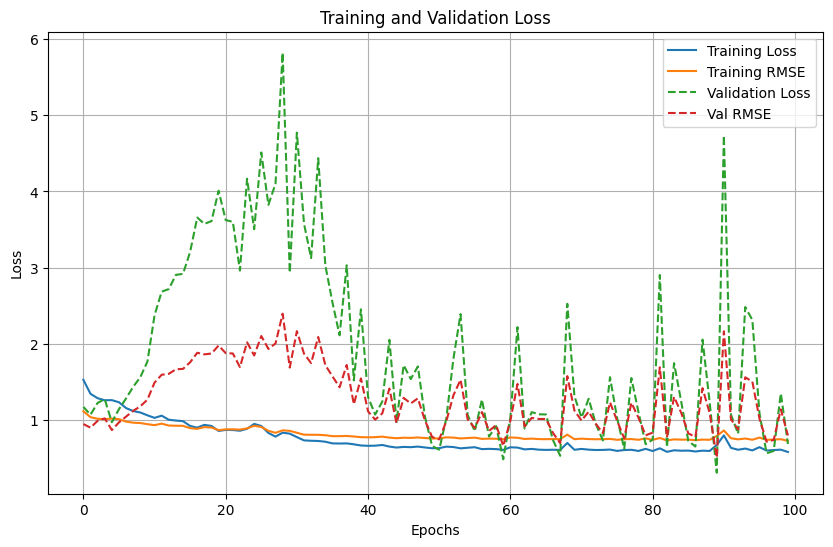

In [205]:
plot_loss(trained_model1)

In [206]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/model_checkpoint.keras')

# **Function: plot_predictions**
**The function prints MSE below each plot**

The plot_predictions1 function is designed to evaluate and visualize the performance of a machine learning model. It generates predictions using the model, reverses any scaling transformations applied to the data, and plots the predictions against the actual values. Additionally, it computes the Mean Squared Error (MSE) to quantify the model’s prediction error.

In [207]:
from sklearn.metrics import mean_squared_error as mse
"""
    Generates predictions using the model, reverses the scaling transformation,
    plots the predictions against actual values, and calculates the Mean Squared Error (MSE).

    Returns:
    tuple: A tuple containing the following:
        - DataFrame with the first few rows of predictions and actuals.
        - DataFrame with the last few rows of predictions and actuals.
        - Mean Squared Error (MSE) between the reversed predictions and actuals.
"""

def plot_predictions(model, X, y, start=1300, end= 2000):

  # Generate predictions
  predictions = model.predict(X).flatten()

  # Inverse transform predictions and actual values
  pred_revr = sc2.inverse_transform(predictions.reshape(-1,1))
  actul_revr = sc2.inverse_transform([y])

  # Create a DataFrame for predictions and actual values
  df = pd.DataFrame(data={'Predictions': pred_revr.flatten(), 'Actuals':actul_revr.flatten()})

  # Plotting
  plt.figure(figsize=(12, 8))
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])

  # Adding labels and title
  plt.title('Model Predictions vs Actual Values')
  plt.xlabel('Date')
  plt.ylabel('Trading Volume (Target Variable)')

  # Adding legend
  plt.legend(loc='best')
  plt.show()

  return mse(predictions, y)

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


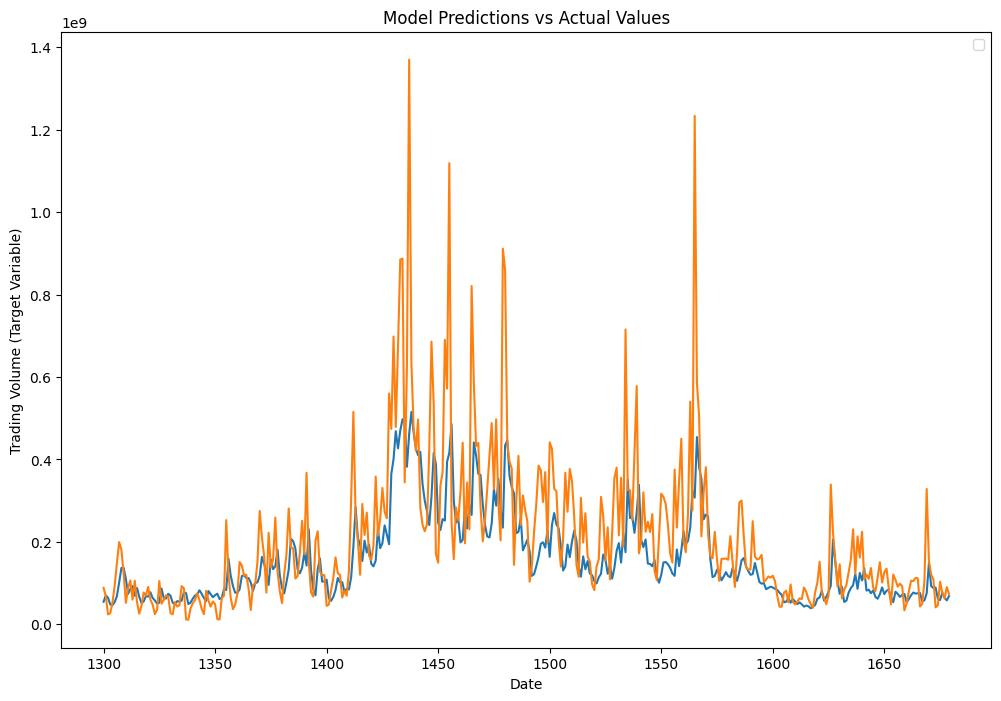

0.9357848674267213

In [208]:
plot_predictions(model1, X1_train, y1_train) # Evaluate the performance of a trained model and visualize on a specific subset of the training data.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


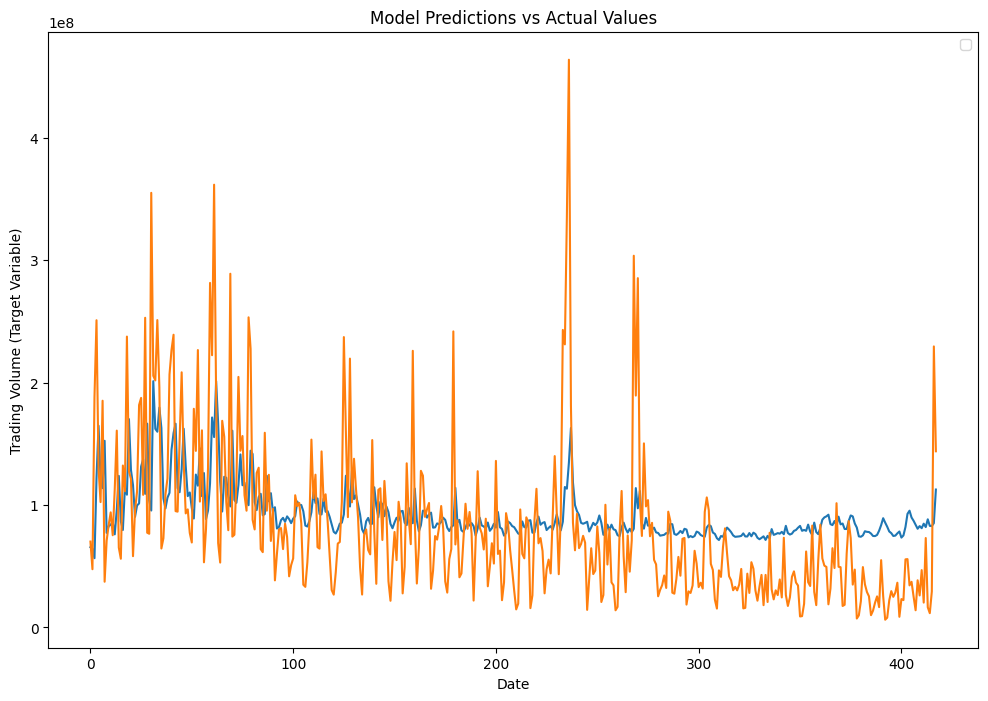

0.2532352442220247

In [209]:
plot_predictions(model1, X1_val, y1_val, start=0, end=600) # Evaluate the performance of a trained model and visualize on a specific subset of the validation data.

# **Setting up a GRU(64) model**

In [228]:
# Defining the model

model1 = Sequential()
model1.add(GRU(64, input_shape=(5, 321), kernel_regularizer=l2(0.001)))
model1.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001)))
model1.add(Dense(1, activation='linear'))

# model2 = Sequential()
# model2.add(InputLayer((5, 321)))
# model2.add(GRU(64))
# model2.add(Dense(8, 'relu'))
# model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 64)                  │          74,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,501 (876.96 KB)

 Trainable params: 74,833 (292.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 149,668 (584.64 KB)

In [229]:
# Setting up the model checkpoint
cp2 = ModelCheckpoint('model2/model_checkpoint.keras', save_best_only=True)

# Compiling the model
model2.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0008),
    metrics=[RootMeanSquaredError()]
              )

In [230]:
# Fitting the model
trained_model2 = model2.fit(
    X1_train, y1_train,
    validation_data=(X1_val, y1_val),
    epochs=100,
    verbose=False,
    callbacks=[cp2]
         )

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.5046 - root_mean_squared_error: 0.7056 - val_loss: 0.8101 - val_root_mean_squared_error: 0.9000
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4896 - root_mean_squared_error: 0.6980 - val_loss: 0.9085 - val_root_mean_squared_error: 0.9532
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3575 - root_mean_squared_error: 0.5945 - val_loss: 0.8237 - val_root_mean_squared_error: 0.9076
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4146 - root_mean_squared_error: 0.6395 - val_loss: 0.8914 - val_root_mean_squared_error: 0.9442
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4365 - root_mean_squared_error: 0.6541 - val_loss: 0.8749 - val_root_mean_squared_error: 0.9354
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3919 - root_mean_squared_error: 0.6216 - val_loss: 0.9445 - val_root_mean_squared_error: 0.9718
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - lo

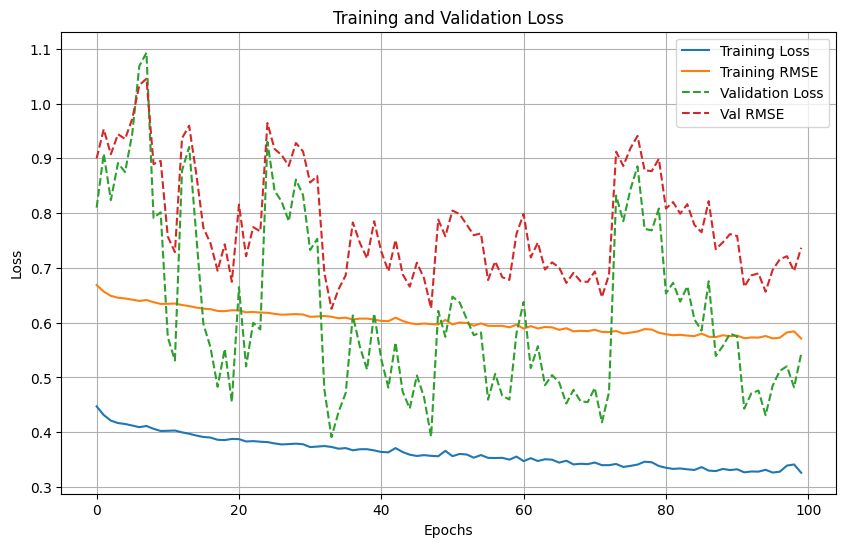

In [231]:
plot_loss(trained_model2)

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


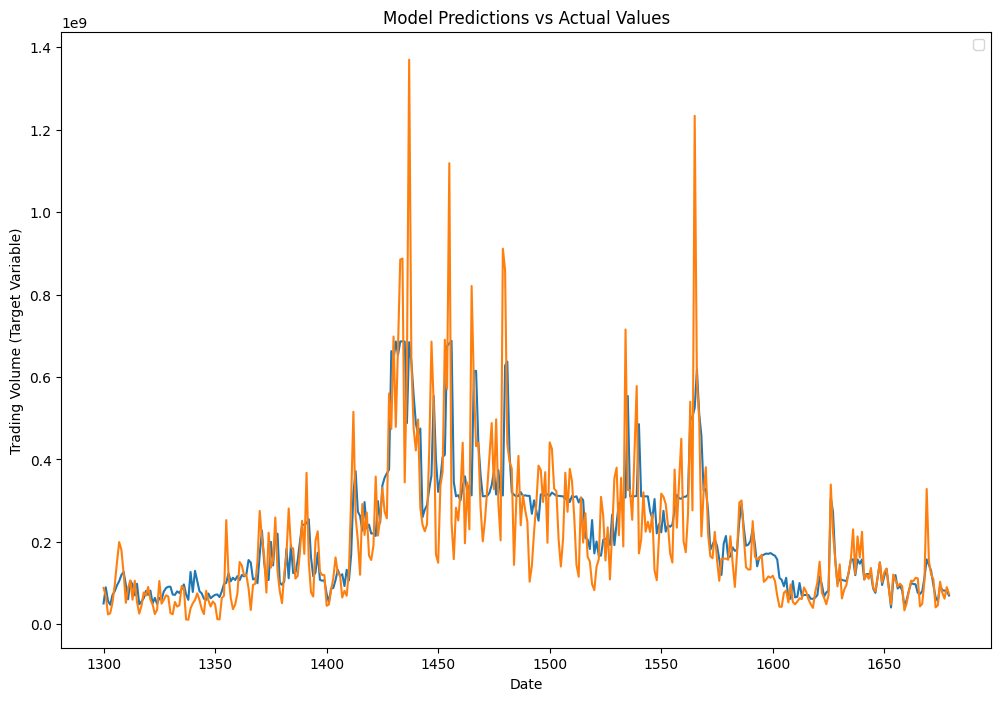

0.3171630078175051

In [232]:
plot_predictions(model2, X1_train, y1_train)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


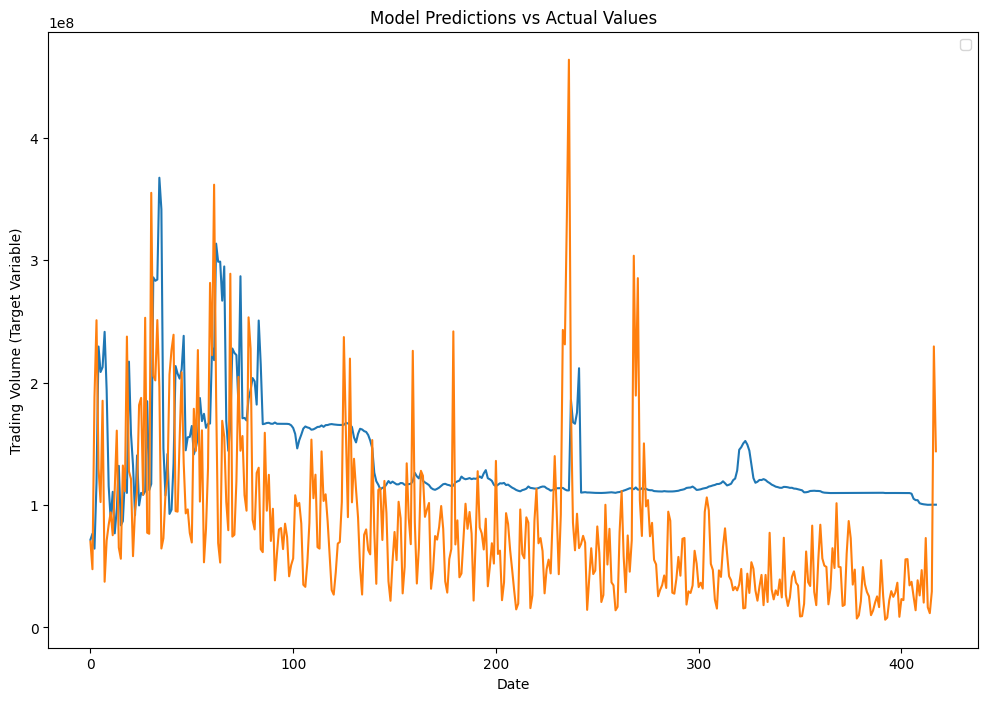

0.5428114890057297

In [233]:
plot_predictions(model2, X1_val, y1_val, start=0, end=600)

# In this exercise, LSTM performs better on validation set compared to GRU. Although I have tried my best to avoid overfitting by reducing the model complexity and introducing L2 penalty, the overfitting possibility cannot be totally ruled out.

# At this point, for the same configuration, MSE on validation for LSTM is 0.25 whereas for GRU is 0.54

# The plots also help in visualizing the predictions being generated.